# Time of Emergence of the Global Mean

This version differs from the previous version as it is constucted from draft_03_v2 which uses version that have been shifted to functions and standardised.

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import climate_utils
import plotting_utils
import stats
import time_of_emergence_plots
import time_of_emrgence_calc as toe
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary cache directory at /jobfs/119140191.gadi-pbs/matplotlib-9tblvl_1 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import matplotlib.patches as patches

In [3]:

import matplotlib.pylab as pylab
params = {'axes.labelsize' : 'xx-large', 'legend.fontsize': 'xx-large', 
          'xtick.labelsize': 'xx-large', 'ytick.labelsize': 'xx-large'}
            
pylab.rcParams.update(params)

In [4]:
# from dask.distributed import Client
# client = Client()
# client

In [5]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# Opening Best

In [6]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Complete_TAVG_LatLong1.nc',
 'best_mask_old.zarr',
 'best_mask.zarr',
 'Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [7]:
best_ds = open_data.open_best()

Opening best dataset from - /g/data/w40/ab2313/PhD/time_of_emergence/best/Land_and_Ocean_LatLong1_time_chunk.zarr
  -- overriding time to use cftime
  -- resampling to yearly mean


In [8]:
best_ds_smean = climate_utils.weighted_lat_lon_mean(best_ds)

In [9]:
# Only 43MB - load into memory
best_ds_smean = best_ds_smean.compute()

In [10]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1900, 1950)#(1900, 1931)
best_ds_smean = best_ds_smean.sel(time=best_ds_smean.time.dt.year>=start_end_tuple[0])
best_ds_smean

<xarray.DataArray 'temperature' (time: 125)> Size: 500B
-0.1194 -0.1957 -0.3539 -0.4568 -0.5062 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

In [11]:
base_period_ds = best_ds_smean.where(best_ds_smean.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50)> Size: 200B
-0.1194 -0.1957 -0.3539 -0.4568 -0.5062 ... -0.07889 -0.01591 -0.1134 -0.11
Coordinates:
  * time     (time) object 400B 1900-12-31 00:00:00 ... 1949-12-31 00:00:00

In [12]:
base_period_ds_average = base_period_ds.mean(dim='time')
base_period_ds_average

<xarray.DataArray 'temperature' ()> Size: 4B
-0.2

In [13]:
# Resetting the anomlies to 1850
best_ds_smean = best_ds_smean - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

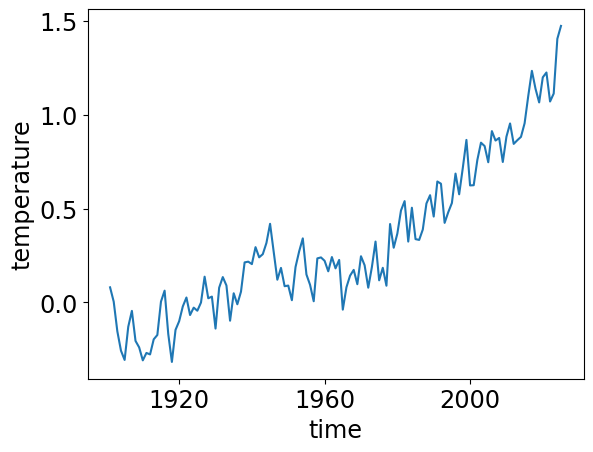

In [14]:
best_ds_smean.plot()

# Calculations

In [15]:
window = 20

## Signal-to-Noise

In [16]:
# As these are anomalies, the signal is just going to be the
ds_best_smooth = stats.trend_fit(best_ds_smean, 'LOWESS', lowess_window=41)#method='POLYNOMIAL', order=4)#

In [17]:
# noise_ds = base_period_ds.std(dim='time').to_numpy()
# noise_ds

In [18]:
noise_ds = (best_ds_smean-ds_best_smooth).std().to_numpy()
noise_ds

array(0.10585574)

In [19]:
# I know that the temperature is already an anomly, but it cleary wasn't in 
# reference to my base period. This should just translate the data updwardss,
# increasing the signal, so that the baser period is now centered on zero.

ds_best_smooth_signal = ds_best_smooth#- base_period_ds_average

In [20]:
ds_best_sn = ds_best_smooth_signal/noise_ds
ds_best_sn

<xarray.DataArray 'temperature' (time: 125)> Size: 1kB
-2.131 -2.067 -2.001 -1.934 -1.865 -1.795 ... 10.87 11.1 11.33 11.55 11.78 12.01
Coordinates:
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

In [21]:
ds_best_sn.attrs = {'longname': 'Signal-to-Noise Ratio'}

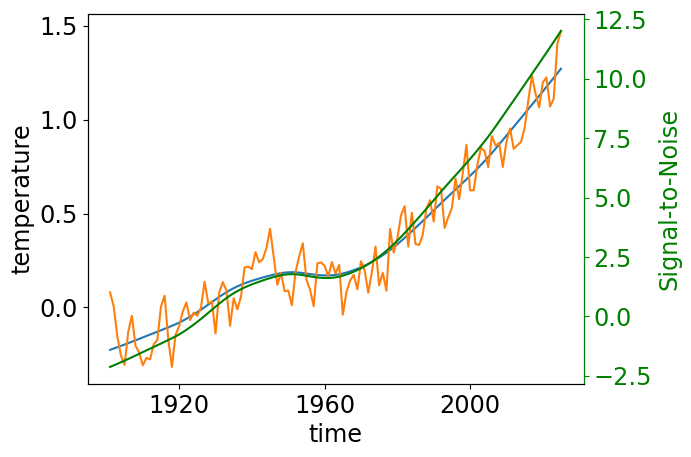

In [22]:
fig, ax = plt.subplots()
ax_twinx = ax.twinx()
ds_best_smooth.plot(ax=ax)
best_ds_smean.plot(ax=ax)
ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-Noise', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

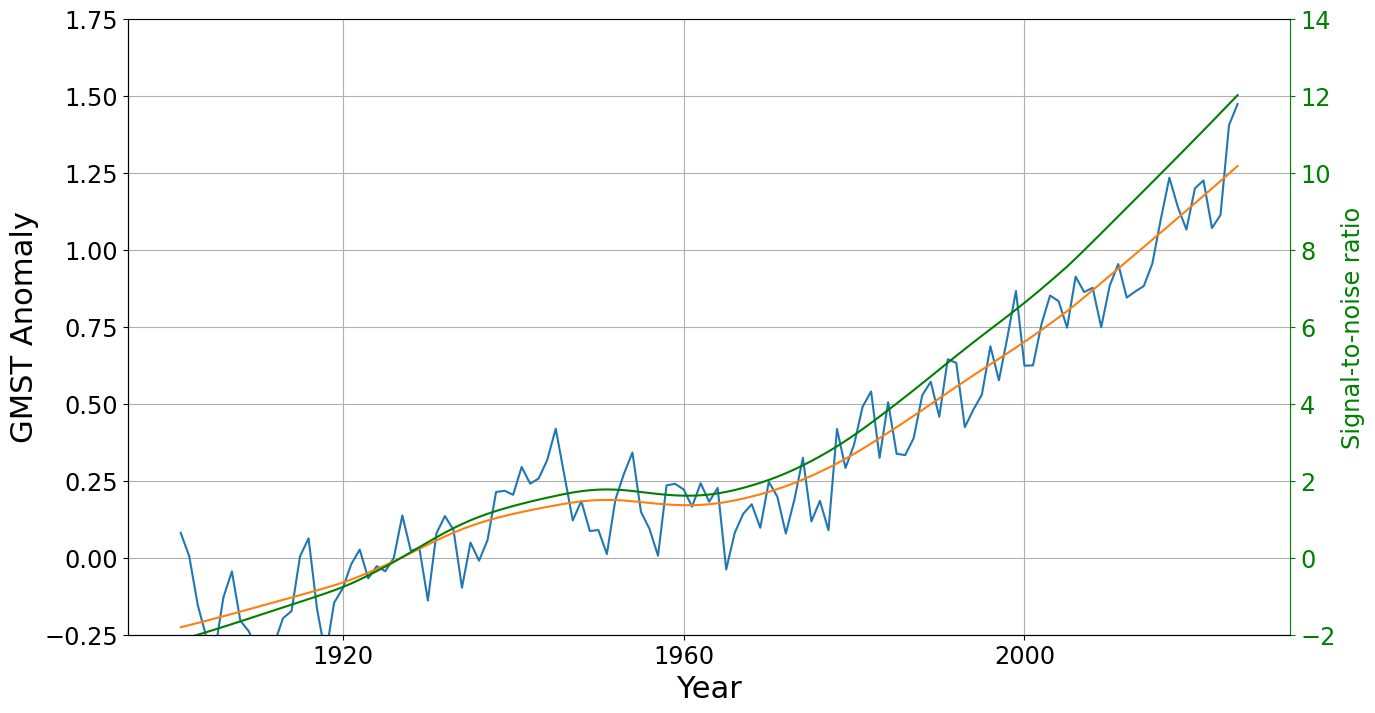

In [23]:
fig, ax = plt.subplots(figsize=(15, 8))
best_ds_smean.plot(ax=ax)
ds_best_smooth.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly', fontsize=22)
ax.set_xlabel('Year', fontsize=22)

ax_twinx = ax.twinx()


ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

ax.set_ylim(-0.25, 1.75)
ax1 = ax
ax2 = ax_twinx
ax2.set_ylim(-2,14)
ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 9))
ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 9))

ax.grid(True)


In [24]:
best_ds_smean.time[best_ds_smean.time.dt.year == 1935].values

array([cftime.DatetimeGregorian(1935, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)

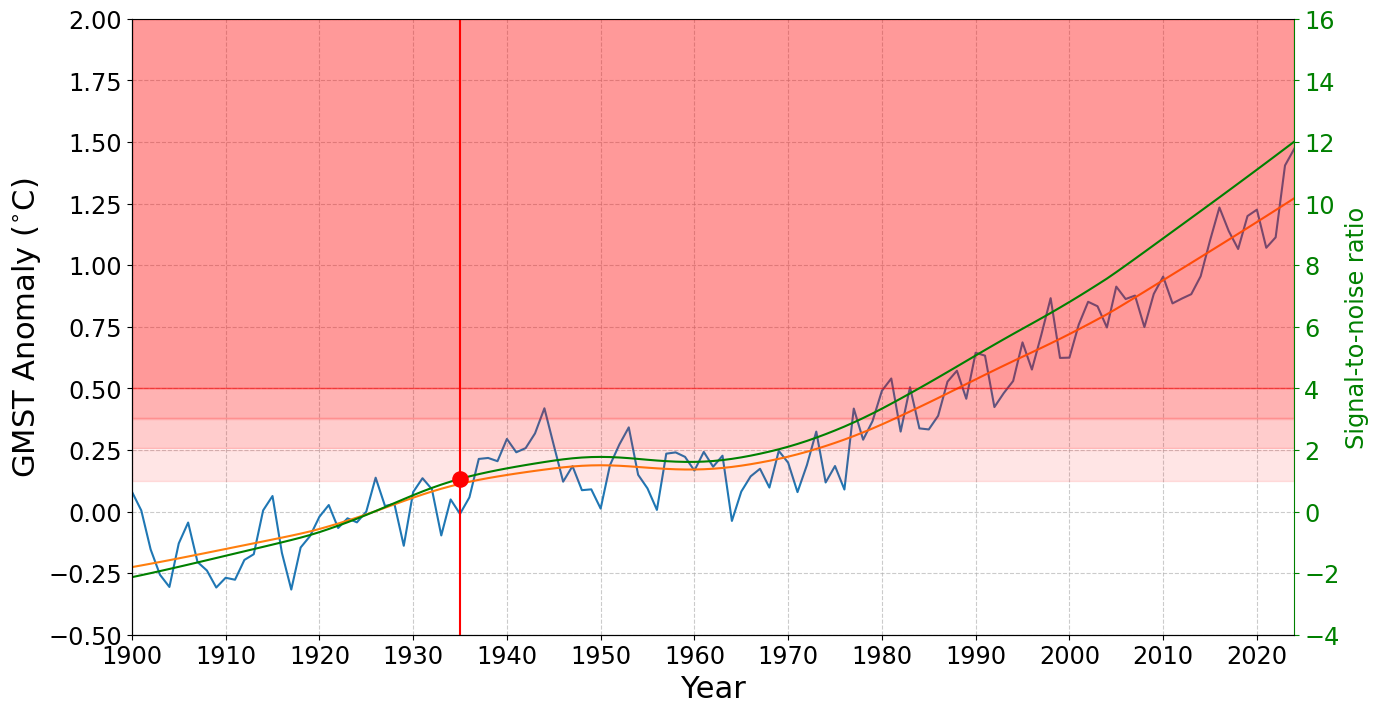

In [25]:
fig, ax = plt.subplots(figsize=(15, 8))
time = best_ds_smean.time.values
best_ds_smean.plot(ax=ax)
ds_best_smooth.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly ($^{\circ}$C)', fontsize=22)
ax.set_xlabel('Year', fontsize=22)

ax.grid(True, linestyle='--', alpha=0.65)
ax.set_xlim(*np.take(ds_best_sn.time.values,[0, -1]))
ax.set_ylim(-0.5, 2)

tick_locations = list(filter(lambda t: t.year % 10 == 0, time))
ax.set_xticks(tick_locations);
ax.set_xticklabels(list(map(lambda t:t.year, tick_locations)));


#### Phase 2
ax_twinx = ax.twinx()

ds_best_sn.plot(ax=ax_twinx, color='green')


ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')


ax_twinx.set_ylim(-4,16);
ax.set_yticks(np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 11));
ax_twinx.set_yticks(np.linspace(ax_twinx.get_ybound()[0], ax_twinx.get_ybound()[1], 11));

#### Phase 3

ax_twinx.axhspan(1, 2, color='red', alpha=0.1)
ax_twinx.axhspan(2.05, 3, color='red', alpha=0.2)
ax_twinx.axhspan(3.05, 4, color='red', alpha=0.3)
ax_twinx.axhspan(4., 16, color='red', alpha=0.4)


ax_twinx.scatter(ds_best_sn.time[ds_best_sn.time.dt.year == 1935].values[0], ds_best_sn[ds_best_sn.time.dt.year == 1935].values[0], 
           s=120, color='red', zorder=1000)

ax_twinx.axvline(ds_best_sn.time[ds_best_sn.time.dt.year == 1935].values[0], color='r')

(-36160.0, 9131.0)

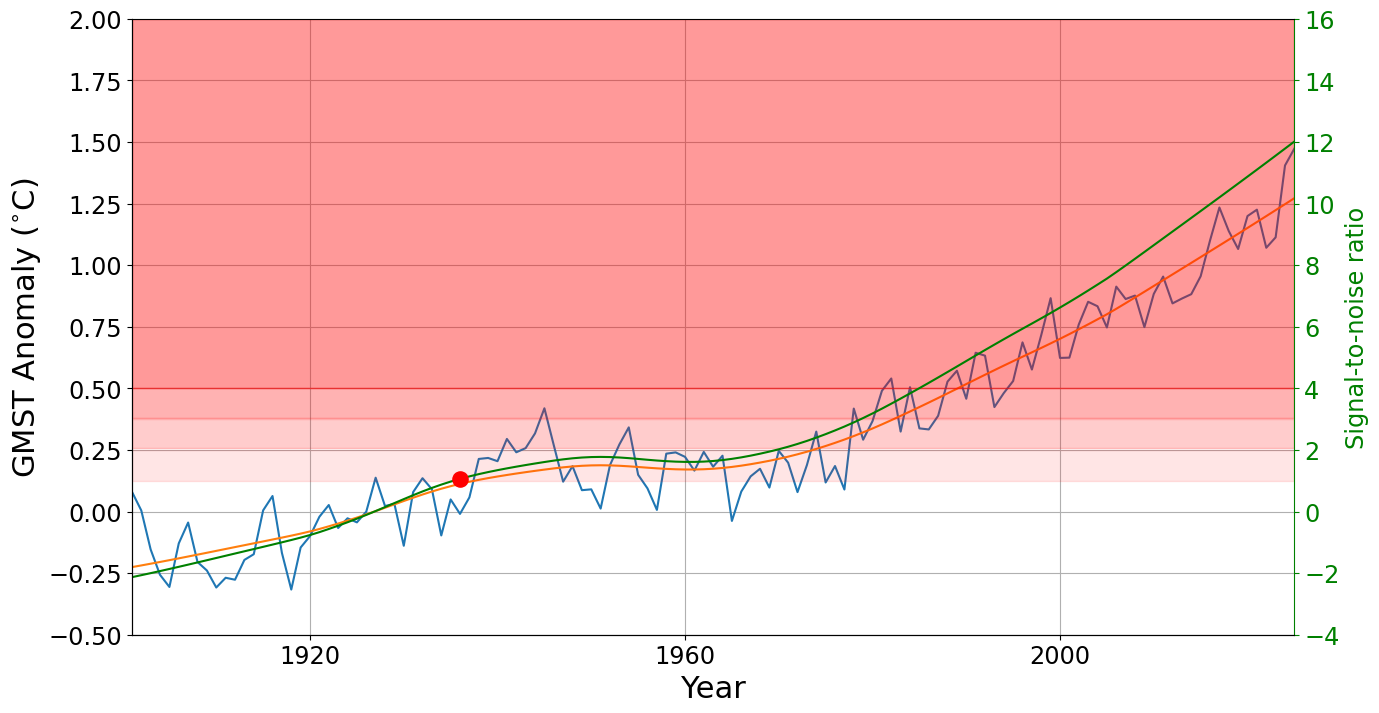

In [26]:
fig, ax = plt.subplots(figsize=(15, 8))

best_ds_smean.plot(ax=ax)
ds_best_smooth.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly ($^{\circ}$C)', fontsize=22)  # Corrected axis label
ax.set_xlabel('Year', fontsize=22)

ax_twinx = ax.twinx()

ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

ax.set_ylim(-0.5, 2)

ax1 = ax
ax2 = ax_twinx
# ax2.set_ylim(-2,14)
ax2.set_ylim(-4,16)

ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 11))
ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 11))

ax2.axhspan(1, 2, color='red', alpha=0.1)
ax2.axhspan(2.05, 3, color='red', alpha=0.2)
ax2.axhspan(3.05, 4, color='red', alpha=0.3)
ax2.axhspan(4., 16, color='red', alpha=0.4)

ax.grid(True)

ax2.scatter(ds_best_sn.time[ds_best_sn.time.dt.year == 1935].values[0], ds_best_sn[ds_best_sn.time.dt.year == 1935].values[0], 
           s=120, color='red', zorder=1000)

ax.set_xlim(*np.take(ds_best_sn.time.values,[0, -1]))

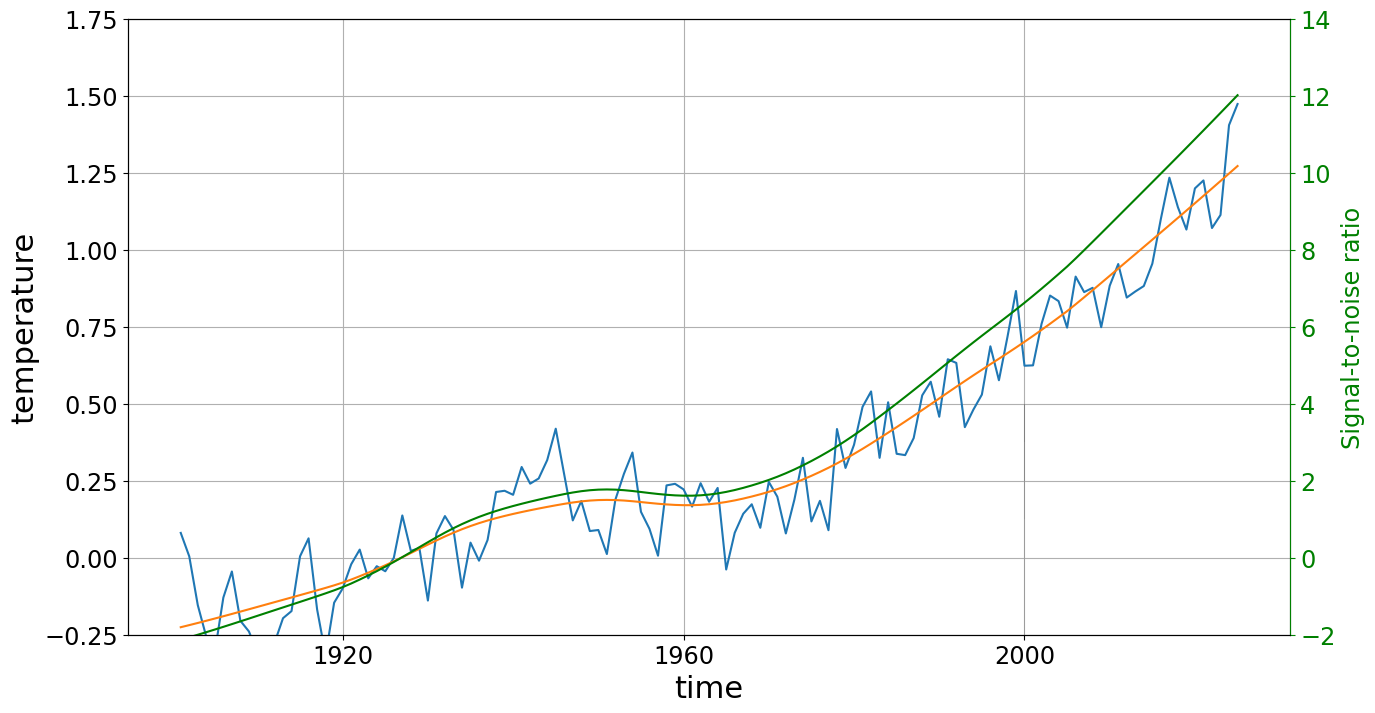

In [27]:
fig, ax = plt.subplots(figsize=(15, 8))
ax_twinx = ax.twinx()


# Define the rectangular patches on the secondary y-axis
xstart = ax_twinx.get_xbound()[0]
width = np.sum(np.abs(ax_twinx.get_xbound()))

rect1 = patches.Rectangle((xstart, -2), width, 3, edgecolor=None, alpha=0.4, facecolor='grey', zorder=1)
rect2 = patches.Rectangle((xstart, 1), width, 1, edgecolor=None, alpha=0.6, facecolor='grey', zorder=1)
rect3 = patches.Rectangle((xstart, 2), width, 1, edgecolor=None, alpha=0.8, facecolor='grey', zorder=1)
rect4 = patches.Rectangle((xstart, 3), width, 1, edgecolor=None, alpha=1, facecolor='grey', zorder=1)

# Add patches to the secondary y-axis
ax_twinx.add_patch(rect1)
ax_twinx.add_patch(rect2)
ax_twinx.add_patch(rect3)
ax_twinx.add_patch(rect4)

# Plot on the secondary y-axis
ds_best_sn.plot(ax=ax_twinx, color='green', zorder=2)  # Ensure the plot is in front

# Labels and grid
ax.set_ylabel('GMST Anomaly', fontsize=22)
ax.set_xlabel('Year', fontsize=22)
ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', colors='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

ax.set_ylim(-0.25, 1.75)
ax_twinx.set_ylim(-2, 14)
ax.set_yticks(np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 9))
ax_twinx.set_yticks(np.linspace(ax_twinx.get_ybound()[0], ax_twinx.get_ybound()[1], 9))


# Plot on the primary y-axis
best_ds_smean.plot(ax=ax, zorder=3)  # Ensure these plots are in front
ds_best_smooth.plot(ax=ax, zorder=3)  # Ensure these plots are in front

ax.grid(True)



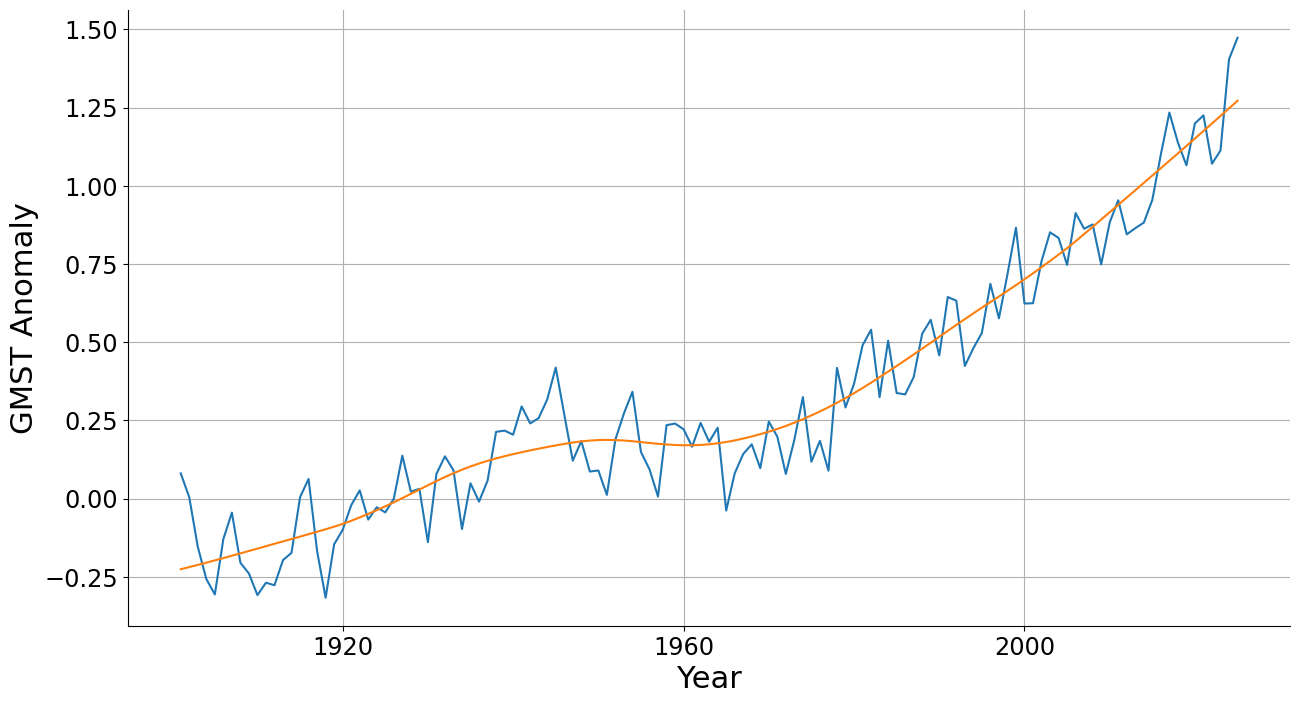

In [28]:
fig, ax = plt.subplots(figsize=(15, 8))
best_ds_smean.plot(ax=ax)
ds_best_smooth.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly', fontsize=22)
ax.set_xlabel('Year', fontsize=22)
ax.grid(True)

## p-value tests

In [29]:
# This version is better
ks_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_ks_pvalue)
ttest_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_ttest_pvalue)
anderson_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_anderson_pvalue)

In [30]:
frac_geom_ds = toe.stats_test_1d_xr(best_ds_smean, window=30, stats_func=toe.farctional_geometric_area)
perkins_ds = toe.stats_test_1d_xr(best_ds_smean, window=30, stats_func=toe.perkins_skill_score)

In [31]:
ks_ds

<xarray.DataArray 'temperature' (time: 105)> Size: 840B
0.007284 0.007284 0.007284 0.009469 ... 1.235e-17 1.235e-17 1.235e-17 1.235e-17
Coordinates:
  * time     (time) object 840B 1910-12-31 00:00:00 ... 2014-12-31 00:00:00

# Getting ToE

In [40]:
ds_best_sn.name = 'sn'
ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
anderson_ds.name = 'anderson'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'

In [41]:
# Set long name attributes for each variable
ds_best_sn.attrs['long_name'] = 'Signal to Noise Ratio'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
ttest_ds.attrs['long_name'] = 'T-Test'
anderson_ds.attrs['long_name'] = 'Anderson-Darling'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'

In [57]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, anderson_ds, ds_best_sn, perkins_ds, frac_geom_ds])
toe_metrics_ds = toe_metrics_ds.isel(time=slice(None, -int(window/2))) #int(window/2)
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

<xarray.Dataset> Size: 6kB
Dimensions:   (time: 115)
Coordinates:
  * time      (time) object 920B 1900-12-31 00:00:00 ... 2014-12-31 00:00:00
Data variables:
    ks        (time) float64 920B nan nan nan ... 1.235e-17 1.235e-17 1.235e-17
    ttest     (time) float64 920B nan nan nan ... 3.803e-31 1.891e-31 2.57e-31
    anderson  (time) float64 920B nan nan nan nan ... 0.001 0.001 0.001 0.001
    sn        (time) float64 920B -2.131 -2.067 -2.001 ... 9.311 9.533 9.755
    perkins   (time) float64 920B nan nan nan nan nan ... nan nan nan nan nan
    frac      (time) float64 920B nan nan nan nan nan ... nan nan nan nan nan
Attributes: (1)

In [58]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['sn']), threshold=1, comparison_func=np.greater_equal)
ks_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ks'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
ttest_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ttest'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
anderson_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['anderson'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
# # The distribution overlap methods
perkins_toe_ds = toe.get_permanent_exceedance(perkins_ds, threshold=OVERLAP_THRESHOLD, comparison_func=np.less_equal)
frac_geom_toe_ds = toe.get_permanent_exceedance(frac_geom_ds, threshold=OVERLAP_THRESHOLD, comparison_func=np.less_equal)
toe_ds = xr.merge([sn_toe_ds, ks_toe_ds,ttest_toe_ds , anderson_toe_ds, perkins_toe_ds, frac_geom_toe_ds])
# If have emerged too late, it has not emerged
toe_ds = xr.where(toe_ds<2015, toe_ds, np.nan)


In [59]:
toe_ds

<xarray.Dataset> Size: 48B
Dimensions:   ()
Data variables:
    sn        float64 8B 1.935e+03
    ks        float64 8B 1.939e+03
    ttest     float64 8B 1.935e+03
    anderson  float64 8B 1.936e+03
    perkins   float64 8B 1.94e+03
    frac      float64 8B 1.945e+03

# Plotting

In [60]:
print(toe_ds.to_pandas().astype(int))

sn          1935
ks          1939
ttest       1935
anderson    1936
perkins     1940
frac        1945
dtype: int64


In [72]:
reload(time_of_emergence_plots)

<module 'time_of_emergence_plots' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emergence_plots.py'>

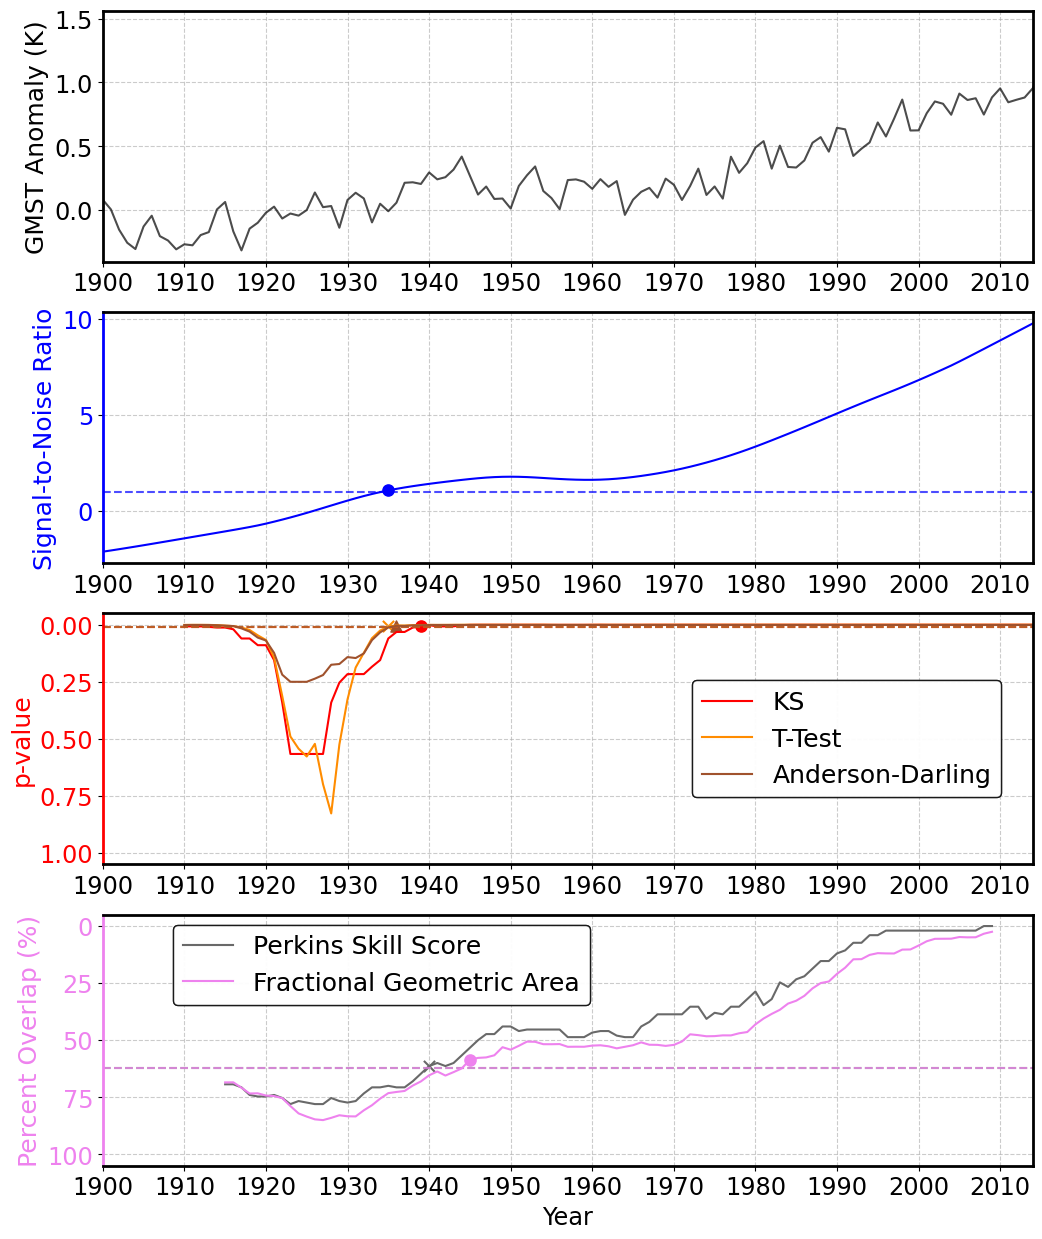

In [73]:
fig, gs, axes = time_of_emergence_plots.plot_multiseries_with_pvalues(
    toe_metrics_ds,
    toe_ds,
    best_ds_smean,
    labels={'ylabel_bottom': 'GMST Anomaly (K)'},
    return_figure=True
    )

# for emergence_test in list(toe_ds.data_vars):
#     toe_st = toe_ds[emergence_test].values.item()
#     xval_emergence = toe_metrics_ds.time.values[toe_metrics_ds.time.dt.year.values==toe_st].item()
#     axes[0].axvline(xval_emergence, color= time_of_emergence_plots.TEST_PLOT_DICT[emergence_test]['color'], 
#               linewidth=3)

In [74]:
test_subset = ['ks', 'sn', 'frac']

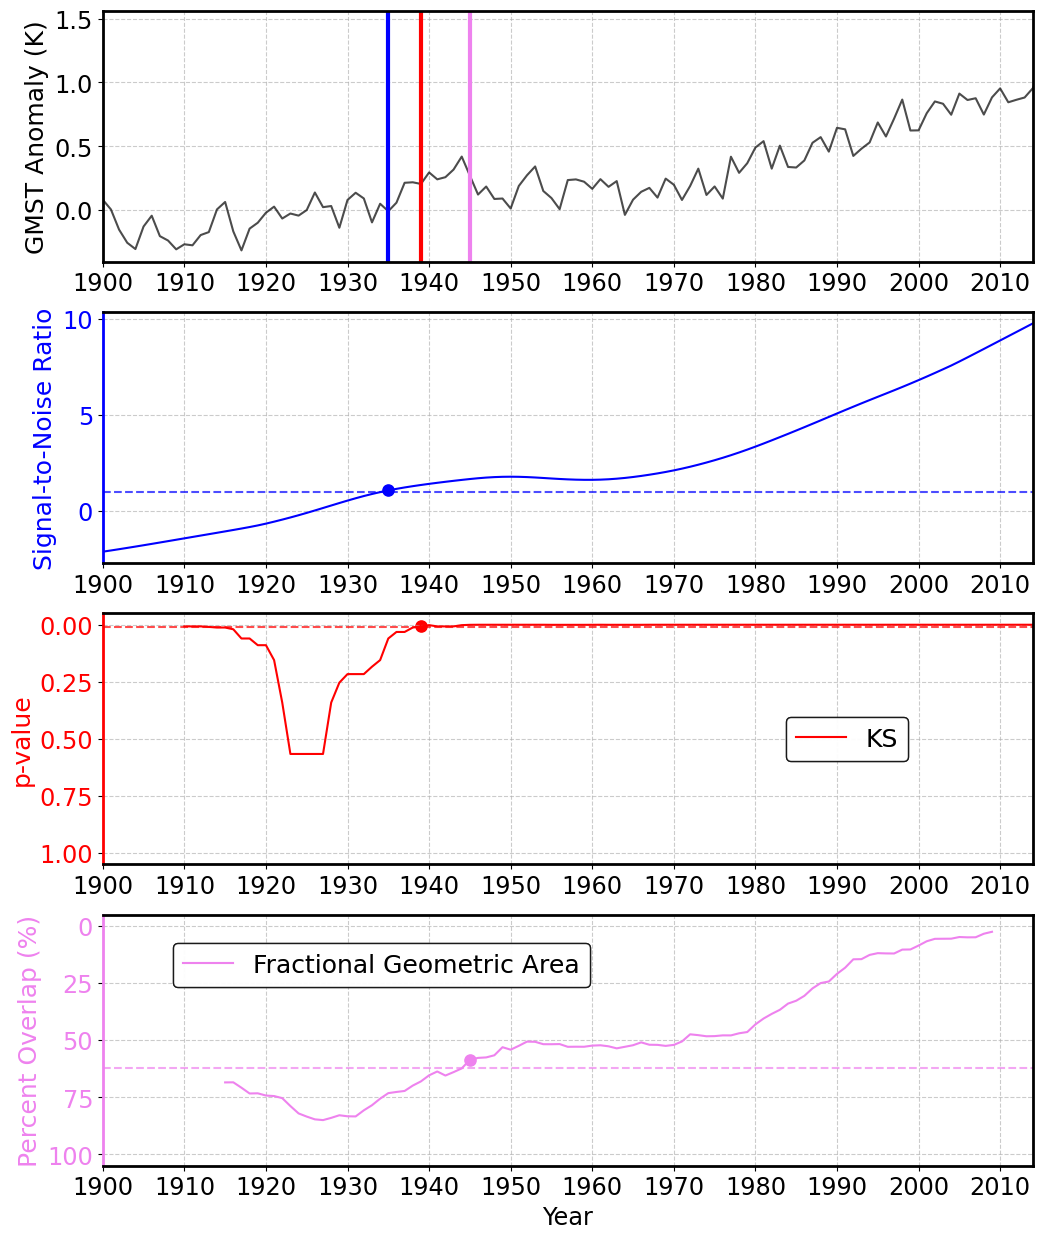

In [77]:
reload(time_of_emergence_plots)
fig, gs, axes = time_of_emergence_plots.plot_multiseries_with_pvalues(
    toe_metrics_ds[test_subset],
    toe_ds[test_subset],
    best_ds_smean,
    labels={'ylabel_bottom': 'GMST Anomaly (K)'},
    return_figure=True
    )

for emergence_test in test_subset:
    toe_st = toe_ds[emergence_test].values.item()
    xval_emergence = toe_metrics_ds.time.values[toe_metrics_ds.time.dt.year.values==toe_st].item()
    axes[0].axvline(xval_emergence, color= time_of_emergence_plots.TEST_PLOT_DICT[emergence_test]['color'], 
              linewidth=3)

In [52]:
central_year  = 1940
period_of_interest_ds = best_ds_smean.sel(time=best_ds_smean.time.dt.year.isin(np.arange(central_year-20, central_year+21)))

In [53]:
bins = np.arange(-0.5, 0.6, .03)

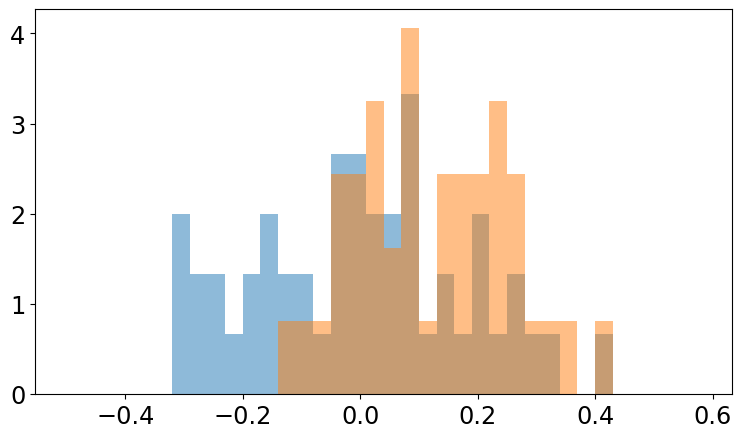

In [54]:
fig, ax  = plt.subplots(figsize=(9, 5))


# base_period_ds.plot(ax=ax)
# period_of_interest_ds.plot(ax=ax)
ax.hist(base_period_ds.values, bins=bins, density=True, alpha=0.5, label='base perdiod');
ax.hist(period_of_interest_ds.values, bins=bins, density=True, alpha=0.5, label='period of interest');
# ax.legend(ncol=1)

# axes_bottom[1].hist(base_period_ds.values, cumulative=True, alpha=0.5);
# axes_bottom[1].hist(period_of_interest_ds.values, cumulative=True, alpha=0.5);

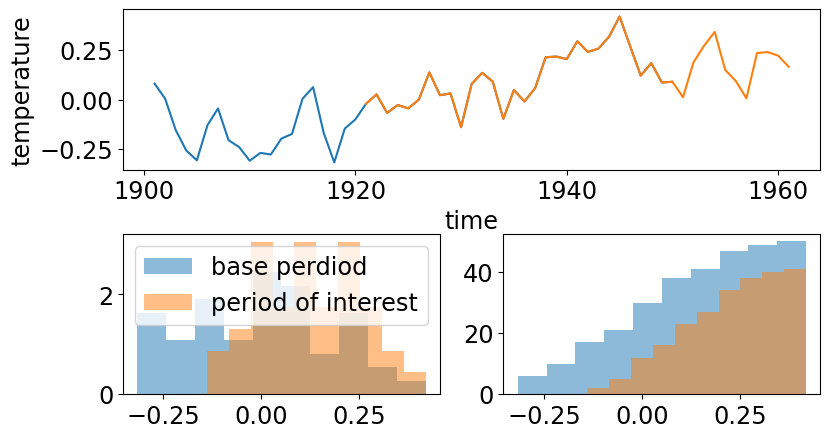

In [55]:
fig  = plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(2, 2, hspace=0.4)
ax_top = fig.add_subplot(gs[0, :])
axes_bottom = [fig.add_subplot(gs[1, i]) for i in [0, 1]]

base_period_ds.plot(ax=ax_top)
period_of_interest_ds.plot(ax=ax_top)
axes_bottom[0].hist(base_period_ds.values, density=True, alpha=0.5, label='base perdiod');
axes_bottom[0].hist(period_of_interest_ds.values, density=True, alpha=0.5, label='period of interest');
axes_bottom[0].legend(ncol=1)

axes_bottom[1].hist(base_period_ds.values, cumulative=True, alpha=0.5);
axes_bottom[1].hist(period_of_interest_ds.values, cumulative=True, alpha=0.5);